# **scVI sanity checks on toy dataset**


In this notebook, we go through several sanity checks to test if scVI has linear propreties

#### Standard imports

In [1]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/owkin/deepdeconv/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/owkin/deepdeconv/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data preparation and model training

# 1.1 Loading and preparing data 

#### Cross-tissue immune cell analysis reveals tissue-specific features in humans - Global

Despite their crucial role in health and disease, our knowledge of immune cells within human tissues remains limited. We surveyed the immune compartment of 16 tissues from 12 adult donors by single-cell RNA sequencing and VDJ sequencing generating a dataset of ~360,000 cells. To systematically resolve immune cell heterogeneity across tissues, we developed CellTypist, a machine learning tool for rapid and precise cell type annotation. Using this approach, combined with detailed curation, we determined the tissue distribution of finely phenotyped immune cell types, revealing hitherto unappreciated tissue-specific features and clonal architecture of T and B cells. Our multitissue approach lays the foundation for identifying highly resolved immune cell types by leveraging a common reference dataset, tissue-integrated expression analysis, and antigen receptor sequencing.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [2]:
## Toy dataset 
adata = scvi.data.heart_cell_atlas_subsampled()

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [3]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

```{important}
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized). scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts (e.g. SoupX-corrected counts), and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

In [4]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [5]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

# 1.2 Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

```{warning}
If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.
```

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [44]:
model = scvi.model.SCVI(adata)

model.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['cell_source', 'donor'],
│   'continuous_covariate_keys': ['percent_mito', 'percent_ribo']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 18641 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 1200  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

               extra_categorical_covs State Registry               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_source'] │ Harvard-Nuclei │          0          │
│                          │  Sanger-CD45   │          1          │
│                          │  Sanger-Cells  │          2          │
│                          │ Sanger-Nuclei  │          3          │
│                          │                │                     │
│    adata.obs['donor']    │       D1       │          0          │
│                          │       D2       │          1          │
│                          │       D3       │          2          │
│                          │       D4       │          3          │
│                          │       D5       │          4          │
│                          │       D6       │          5          │
│                          │       D7       │          6          │
│                          │      D11       │          7          │
│                          │       H2       │          8          │
│                          │       H3       │          9          │
│                          │       H4       │         10          │
│                          │       H5       │         11          │
│                          │       H6       │         12          │
│                          │       H7       │         13          │
│                          │                │                     │
└──────────────────────────┴────────────────┴─────────────────────┘

 extra_continuous_covs State 
          Registry           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['percent_mito'] │
│ adata.obs['percent_ribo'] │
└───────────────────────────┘

In [45]:
model.train(max_epochs=300)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/300:   0%|          | 0/300 [00:00<?, ?it/s]

/home/owkin/deepdeconv/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/owkin/deepdeconv/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/300:   0%|          | 1/300 [00:01<09:01,  1.81s/it, v_num=1, train_loss_step=340, train_loss_epoch=370]

/home/owkin/deepdeconv/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 300/300: 100%|██████████| 300/300 [08:26<00:00,  1.65s/it, v_num=1, train_loss_step=265, train_loss_epoch=293]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [08:26<00:00,  1.69s/it, v_num=1, train_loss_step=265, train_loss_epoch=293]


Plot losses

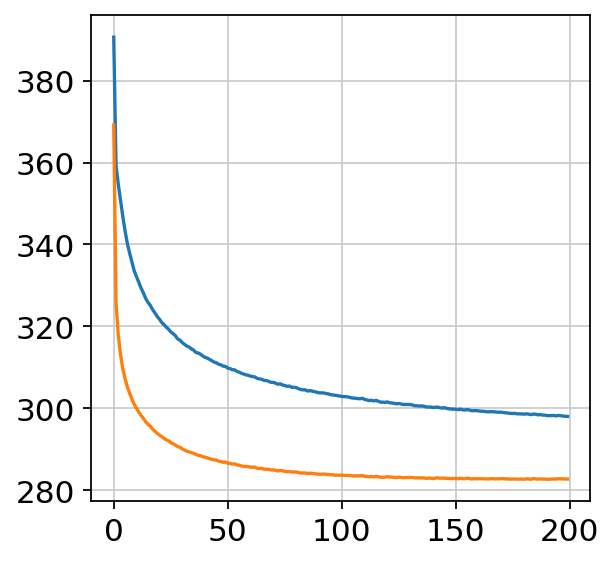

In [34]:
plt.plot(model.history["elbo_train"])
plt.plot(model.history["reconstruction_loss_train"])

Save model and anndata

In [1]:
#model.save("models/toy_200_epochs/")
# adata.write("dirpath/filename.h5ad")

# 2. Load trained models

In [8]:
import os

dir_path = "/home/owkin/deepdeconv/notebooks/models/"
params = ["100", "200", "300", "400"]

models = {}

for param in params:
    model_name = f"toy_{param}_epochs"
    model = scvi.model.SCVI.load(dir_path=os.path.join(dir_path, model_name),
                                adata=adata,
                                use_gpu=True
                                )
    models[param] = model

INFO     File /home/owkin/deepdeconv/notebooks/models/toy_100_epochs/model.pt already downloaded                   


/home/owkin/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


INFO     File /home/owkin/deepdeconv/notebooks/models/toy_200_epochs/model.pt already downloaded                   
INFO     File /home/owkin/deepdeconv/notebooks/models/toy_300_epochs/model.pt already downloaded                   


/home/owkin/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(
/home/owkin/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


INFO     File /home/owkin/deepdeconv/notebooks/models/toy_400_epochs/model.pt already downloaded                   


/home/owkin/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


```{important}
All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.
```

# 3. Visualizations 

#### Latent space

In [36]:
# Regular scVI
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

latent.shape

(18641, 10)

### 2D Embedding plots

UMAP on PCA (Without scVI - no batch correction)

In [19]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


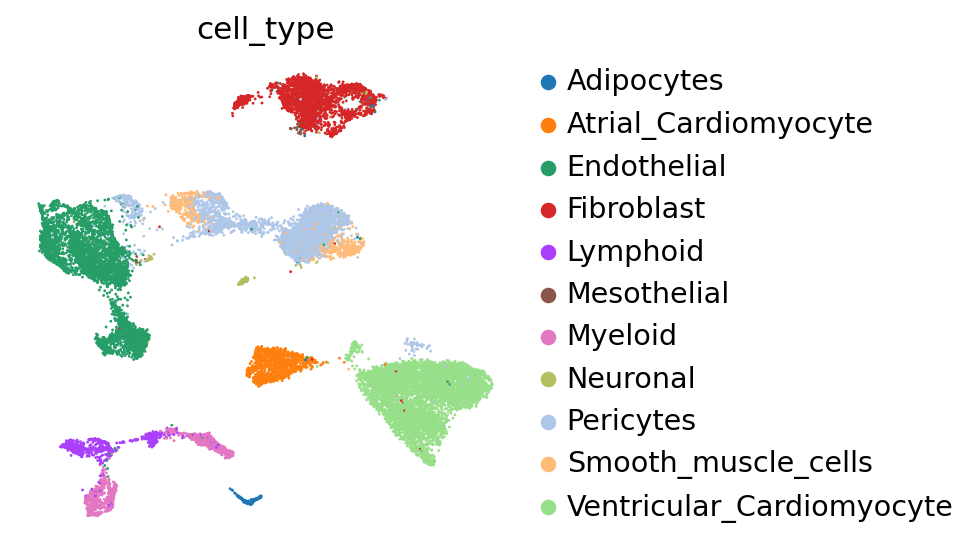

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


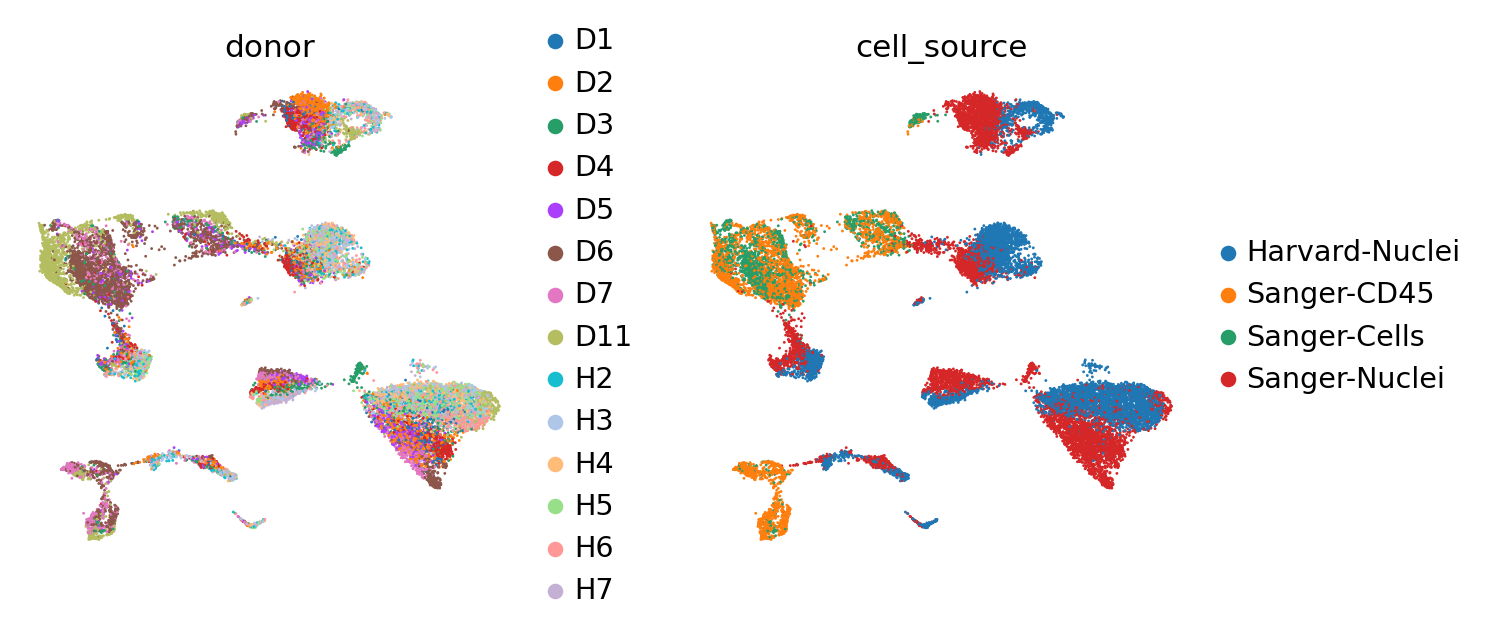

In [20]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

UMAP on scVI latent spae

In [21]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


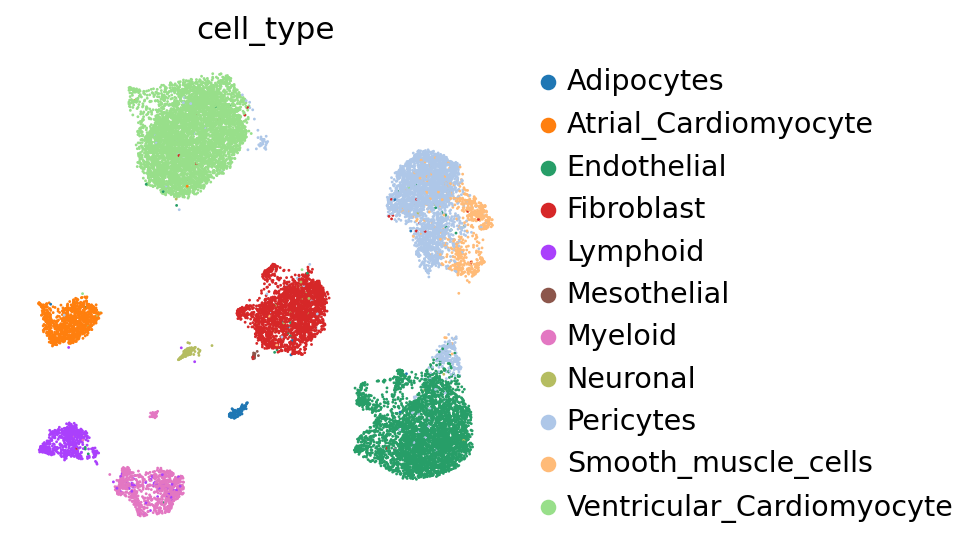

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


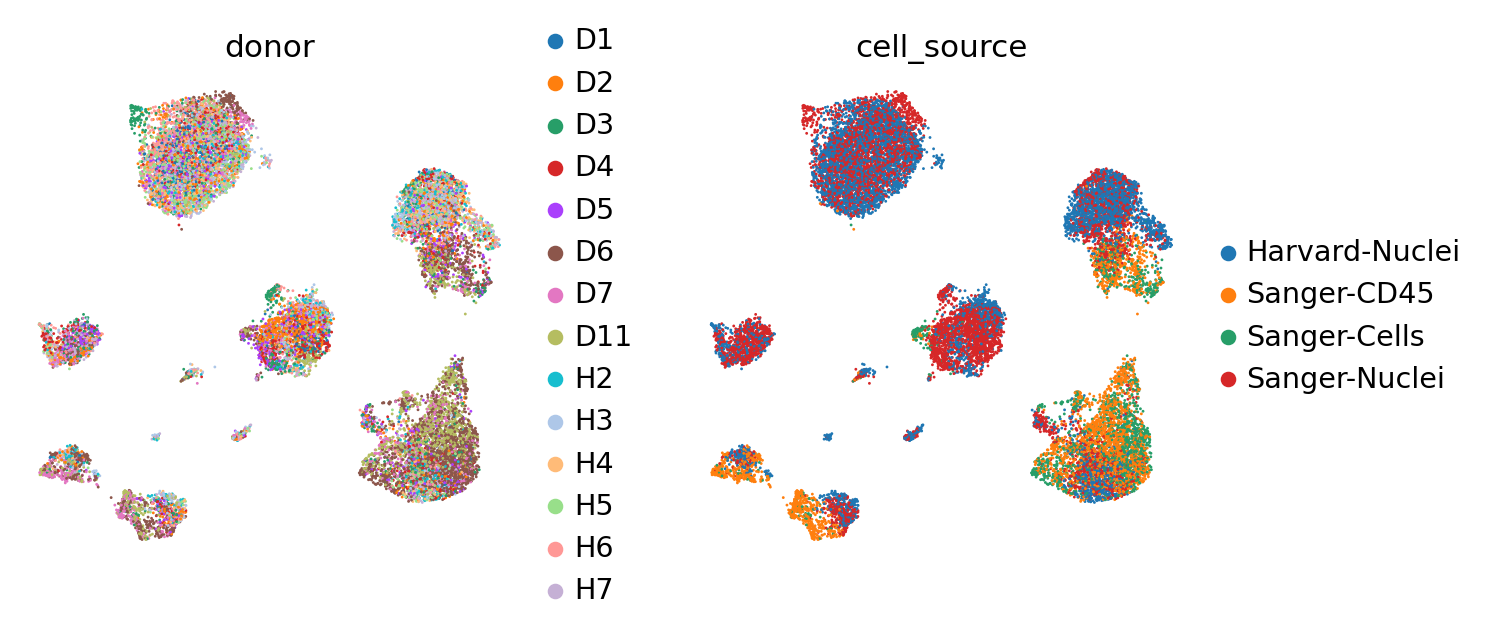

In [23]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

We will use it to compute the **mean gene expression vector for each cell type present in the dataset** .

# 4. Linearity sanity checks

### scVI latent space linearity hypothesis

In [ ]:
import tqdm
from scvi_sanity_checks import sanity_checks_metrics

In [87]:
batch_size = [128, 256, 512, 1024, 2048, 4096, 8192, 16384] #, 32768, 65536, 131072] 

latent_space_metrics = {}

params = [str(x) for x in (100, 200, 300, 400)]

for param in tqdm.tqdm(params[:1]):
    latent_space_metrics[param] = {}
    metrics, errors = sanity_checks_metrics(models[param],
                                            adata,
                                            batch_sizes=batch_size,
                                            n_repeats=100,
                                            use_get_latent=True)
    latent_space_metrics[param]["corr"] = metrics["corr"]
    latent_space_metrics[param]["error"] = errors["corr"]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


  0%|          | 0/4 [00:00<?, ?it/s]


ValueError: counts is not a valid key in adata.layers.

/tmp/ipykernel_912/468969815.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(batch_size,
/tmp/ipykernel_912/468969815.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(batch_size,


Text(0.5, 1.0, 'Sanity check 1: correlation between sum(encodings) & encoder(pseudo-bulk)')

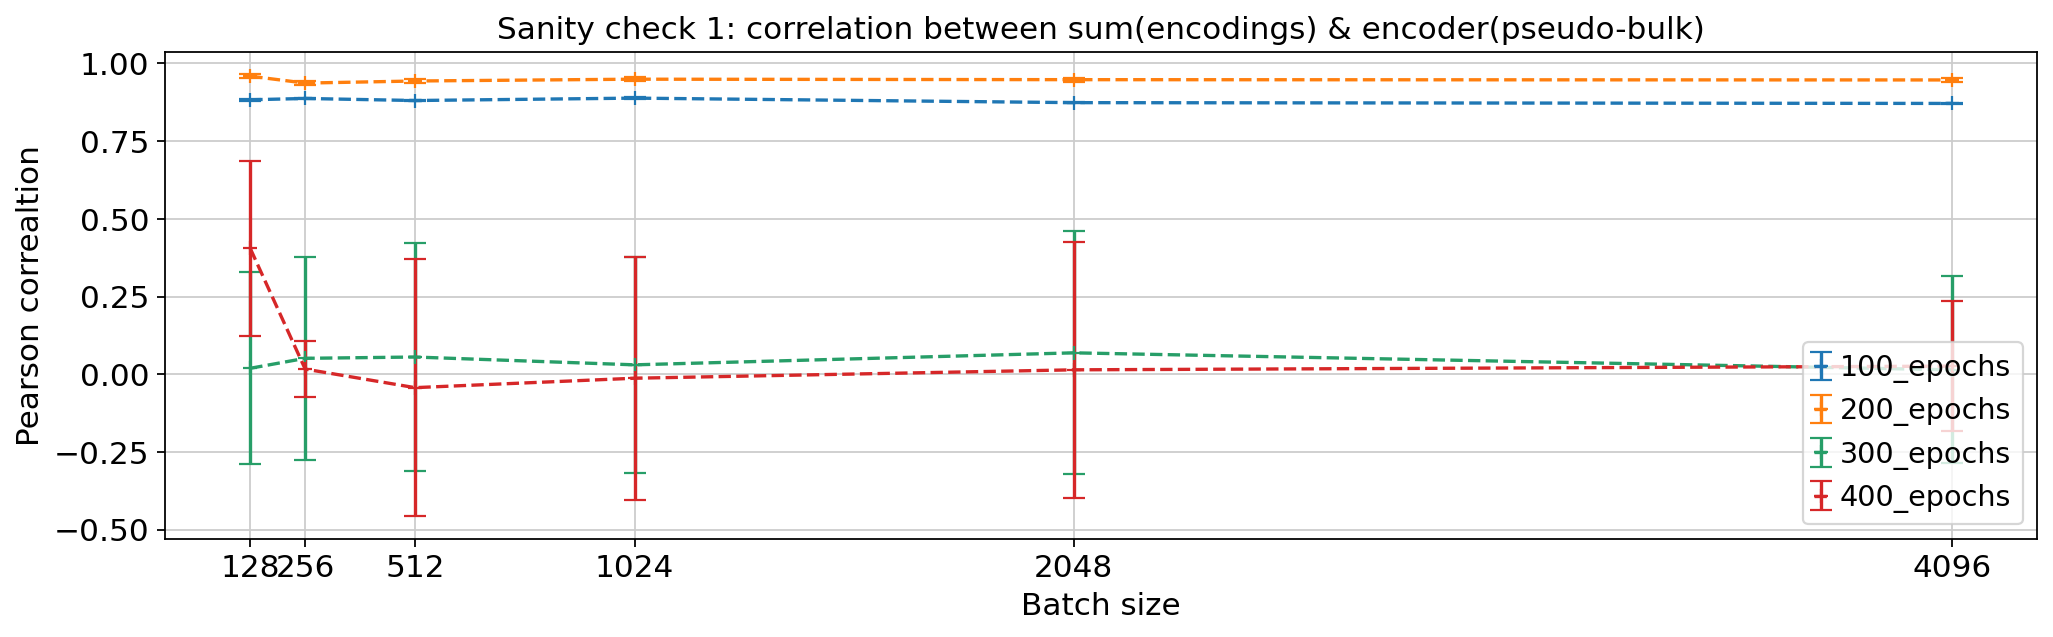

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

for param in params:
        plt.errorbar(batch_size,
                latent_space_metrics[param]["corr"],
                yerr=latent_space_metrics[param]["error"],
                fmt='o-',
                capsize=5,
                linestyle="--", marker="+",
                label=f"{param}_epochs")

    
plt.legend()  
plt.xlabel("Batch size")
plt.ylabel("Pearson correaltion")
plt.xticks(batch_size)

plt.title("Sanity check 1: correlation between sum(encodings) & encoder(pseudo-bulk)")

# [skip] For signature matrix

In [ ]:
# marker_genes = {"Endothelial": ["EGFL7", "VWF", "SLC9A3R2"],
#                 "Neuronal": ["NRXN1", "GPM6B", "L1CAM"],
#                 "Atrial_Cardiomyocyte": ["SYNPR", "MYL7", "KCNJ3"],
#                 "Mesothelial": ["KRT19", "PRG4", "UPK3B"], 
#                 "Ventricular_Cardiomyocyte": ["C15orf41", "GALTN17", "FYB2"],
#                 "Lymphoid" : ["IL7R", "CD2", "GZMA"],
#                 "Myeloid": ["MS4A6A", "SPI1", "MS4A6A"],
#                 "Pericytes": ["HIGD1B", "RGS5", "NOTCH3"],
#                 "Smooth_muscle_cells": ["WFDC1", "MYH11", "ACTG2"],
#                 "Adipocytes": ["CIDEC", "ADIPOQ", "GPAM"],
#                 "Fibroblast": ["CDH19", "MGST1", "FBN1"]
#                 }

# cell_types = list(marker_genes.keys())

# h = 0
# n_rows = 3
# n_cols = 4

# fig, ax = plt.subplots(n_rows, n_cols, figsize=(24, 20))

# for i in range(n_rows):
#     for j in range(n_cols):
#         h += 1
#         if h == len(marker_genes):
#             break
#         cell_type = cell_types[h]
#         x_raw = df_signature[cell_type].values
#         x_denoised = df_signature_denoised[cell_type].values
#         # keep_genes = pd.Index(list(set(marker_genes[cell_type]) & set(adata.var_names)))
#         # x_raw = df_signature.loc[keep_genes][cell_type].values
#         # x_denoised = df_signature_denoised.loc[keep_genes][cell_type].values
#         corr = spearmanr(x_raw, x_denoised)[0]
        
#         sns.scatterplot(x=x_raw,
#                         y=x_denoised,
#                         ax=ax[i][j]
#                         )
#         ax[i][j].set_xlabel(f"Denoised average ({cell_type})")
#         ax[i][j].set_ylabel(f"Raw average ({cell_type})")
#         ax[i][j].set_title(f"Correlation {corr}")
        
